#### Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset 56x56x3


## Pre processing

### Load dataset and process the images

In [3]:
labels = np.load(r"/content/drive/My Drive/dataset_IS/labels.npy")
class_names = np.load(r"/content/drive/My Drive/dataset_IS/class_names.npy")

In [4]:
images = np.load(r"/content/drive/My Drive/dataset_IS/images_56.npy")

#images = np.load(r".\dataset\Dataset\images.npy")
#labels = np.load(r".\dataset\Dataset\labels.npy")
#class_names = np.load(r".\dataset\Dataset\class_names.npy")

# Normalize pixel values to be between 0 and 1
images = images / 255.0

# Split the dataset into training+validation (90%) and test set (10%)
img_train_val, img_test, lb_train_val, lb_test = train_test_split(images, labels, test_size=0.1, random_state=42, stratify=labels)

# Split the training+validation set into actual training (80%) and validation set (10%)
    # 0.11 x 90% ≈ 10% of the total dataset
img_train, img_val, lb_train, lb_val = train_test_split(img_train_val, lb_train_val, test_size=0.11, random_state=0, stratify=lb_train_val)


# Print out the sizes of each split
print(f"Training set: {img_train.shape[0]} images")
print(f"Validation set: {img_val.shape[0]} images")
print(f"Test set: {img_test.shape[0]} images")

Training set: 204255 images
Validation set: 25245 images
Test set: 25500 images


In [5]:
# Function to add Gaussian noise
def add_gaussian_noise(images, mean=0, std=0.1):
    noisy_images = []
    for img in images:
        noise = np.random.normal(mean, std, img.shape)
        noisy_image = img + noise
        noisy_image = np.clip(noisy_image, 0, 1)  # Keep values in [0, 1]
        noisy_images.append(noisy_image)
    return np.array(noisy_images)

In [6]:
img_test_noisy = add_gaussian_noise(img_test, mean=0, std=0.1)

### Plot

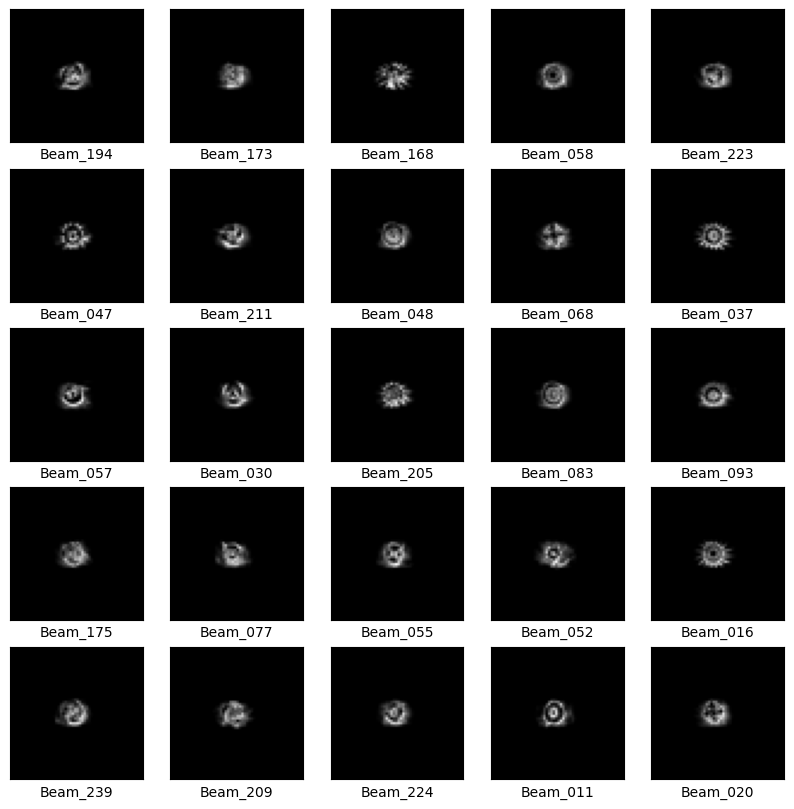

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_train[i].squeeze(), cmap='gray' if img_train[i].shape[-1] == 1 else None)
    plt.xlabel(class_names[lb_train[i]])
plt.show()

## Model 1

### Initialize NN model


In [18]:
def create_model1(input_shape=(56, 56, 3)):

    model = models.Sequential()

    # Flatten the input image
    model.add(layers.Flatten(input_shape=input_shape))

    # First hidden layer
    model.add(layers.Dense(32, activation='relu'))  # 32 neurons, ReLU activation

    # Second hidden layer
    model.add(layers.Dense(32, activation='relu'))   # 32 neurons, ReLU activation

    # Output layer
    model.add(layers.Dense(len(class_names), activation='softmax'))  # Output for classification

    return model

In [19]:
model1=create_model1()
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 9408)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                301088    
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 255)               8415      
                                                                 
Total params: 310559 (1.18 MB)
Trainable params: 310559 (1.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train model


In [20]:
model1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history1 = model1.fit(img_train, lb_train, epochs=5, validation_data=(img_val, lb_val))

Epoch 1/5
6383/6383 [==============================] - 23s 4ms/step - loss: 1.3769 - sparse_categorical_accuracy: 0.6266 - val_loss: 0.6087 - val_sparse_categorical_accuracy: 0.8086
Epoch 2/5
6383/6383 [==============================] - 21s 3ms/step - loss: 0.4801 - sparse_categorical_accuracy: 0.8471 - val_loss: 0.3983 - val_sparse_categorical_accuracy: 0.8706
Epoch 3/5
6383/6383 [==============================] - 21s 3ms/step - loss: 0.3555 - sparse_categorical_accuracy: 0.8843 - val_loss: 0.3117 - val_sparse_categorical_accuracy: 0.8974
Epoch 4/5
6383/6383 [==============================] - 22s 3ms/step - loss: 0.2971 - sparse_categorical_accuracy: 0.9036 - val_loss: 0.2742 - val_sparse_categorical_accuracy: 0.9096
Epoch 5/5
6383/6383 [==============================] - 22s 3ms/step - loss: 0.2635 - sparse_categorical_accuracy: 0.9142 - val_loss: 0.2455 - val_sparse_categorical_accuracy: 0.9179


### Validate model

789/789 - 1s - loss: 0.2455 - sparse_categorical_accuracy: 0.9179 - 1s/epoch - 1ms/step


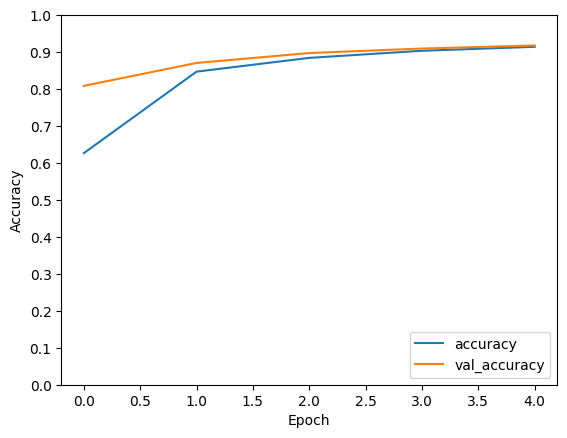

In [21]:
plt.plot(history1.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history1.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc='lower right')

val_loss, val_acc = model1.evaluate(img_val, lb_val, verbose=2)

In [22]:
predictions = model1.predict(img_test)
predictions_noisy = model1.predict(img_test_noisy)

pred_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability
pred_classes_noisy = np.argmax(predictions_noisy, axis=1)  # Get the class with the highest probability

# Calculate precision and recall
precision1 = precision_score(lb_test, pred_classes,average='micro')
precision1_noisy = precision_score(lb_test, pred_classes_noisy,average='micro')

# Print out the sizes of each split
print(f"Precision: {precision1}")
print(f"Precision (Noisy): {precision1_noisy}")


797/797 [==============================] - 1s 1ms/step
Precision: 0.9229019607843137
Precision (Noisy): 0.402


## Model 2

### Initialize NN model


In [ ]:
def create_model2(input_shape=(56, 56, 3)):

    model = models.Sequential()

    # Flatten the input image
    model.add(layers.Flatten(input_shape=input_shape))

    # First hidden layer
    model.add(layers.Dense(32, activation='relu'))  # 32 neurons, ReLU activation

    # Second hidden layer
    model.add(layers.Dense(32, activation='relu'))   # 32 neurons, ReLU activation

    # Third hidden layer
    model.add(layers.Dense(32, activation='relu'))   # 32 neurons, ReLU activation

    # Fourth hidden layer
    model.add(layers.Dense(32, activation='relu'))   # 32 neurons, ReLU activation

    # Output layer
    model.add(layers.Dense(len(class_names), activation='softmax'))  # Output for classification

    return model

In [ ]:
model2=create_model2()
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 9408)              0         
                                                                 
 dense_26 (Dense)            (None, 32)                301088    
                                                                 
 dense_27 (Dense)            (None, 32)                1056      
                                                                 
 dense_28 (Dense)            (None, 32)                1056      
                                                                 
 dense_29 (Dense)            (None, 32)                1056      
                                                                 
 dense_30 (Dense)            (None, 255)               8415      
                                                                 
Total params: 312671 (1.19 MB)
Trainable params: 31267

### Train model


In [ ]:
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history2 = model2.fit(img_train, lb_train, epochs=5, validation_data=(img_val, lb_val))

Epoch 1/5
6383/6383 [==============================] - 29s 4ms/step - loss: 2.4383 - sparse_categorical_accuracy: 0.3069 - val_loss: 1.6578 - val_sparse_categorical_accuracy: 0.4608
Epoch 2/5
6383/6383 [==============================] - 25s 4ms/step - loss: 1.2076 - sparse_categorical_accuracy: 0.6163 - val_loss: 0.9749 - val_sparse_categorical_accuracy: 0.6881
Epoch 3/5
6383/6383 [==============================] - 26s 4ms/step - loss: 0.9132 - sparse_categorical_accuracy: 0.7120 - val_loss: 0.8229 - val_sparse_categorical_accuracy: 0.7464
Epoch 4/5
6383/6383 [==============================] - 26s 4ms/step - loss: 0.7576 - sparse_categorical_accuracy: 0.7614 - val_loss: 0.6180 - val_sparse_categorical_accuracy: 0.8050
Epoch 5/5
6383/6383 [==============================] - 26s 4ms/step - loss: 0.5441 - sparse_categorical_accuracy: 0.8275 - val_loss: 0.5660 - val_sparse_categorical_accuracy: 0.8189


### Validate model

789/789 - 1s - loss: 0.5660 - sparse_categorical_accuracy: 0.8189 - 1s/epoch - 2ms/step


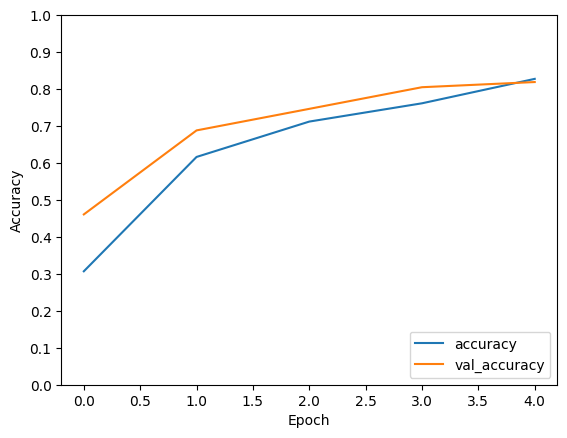

In [ ]:
plt.plot(history2.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history2.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc='lower right')

val_loss, val_acc = model2.evaluate(img_val, lb_val, verbose=2)

In [ ]:
predictions = model2.predict(img_test)
predictions_noisy = model2.predict(img_test_noisy)

pred_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability
pred_classes_noisy = np.argmax(predictions_noisy, axis=1)  # Get the class with the highest probability

# Calculate precision and recall
precision2 = precision_score(lb_test, pred_classes,average='micro')
precision2_noisy = precision_score(lb_test, pred_classes_noisy,average='micro')

# Print out the sizes of each split
print(f"Precision: {precision2}")
print(f"Precision (Noisy): {precision2_noisy}")

797/797 [==============================] - 1s 2ms/step
Precision: 0.8227450980392157
Precision (Noisy): 0.10149019607843138


## Model 3

### Initialize NN model


In [13]:
def create_model3(input_shape=(56, 56, 3)):

    model = models.Sequential()

    # Flatten the input image
    model.add(layers.Flatten(input_shape=input_shape))

    # First hidden layer
    model.add(layers.Dense(64, activation='relu'))  # 64 neurons, ReLU activation

    # Second hidden layer
    model.add(layers.Dense(64, activation='relu'))   # 64 neurons, ReLU activation

    # Output layer
    model.add(layers.Dense(len(class_names), activation='softmax'))  # Output for classification

    return model

In [14]:
model3=create_model3()
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 9408)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                602176    
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 255)               16575     
                                                                 
Total params: 622911 (2.38 MB)
Trainable params: 622911 (2.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train model


In [15]:
model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history3 = model3.fit(img_train, lb_train, epochs=5, validation_data=(img_val, lb_val))

Epoch 1/5
6383/6383 [==============================] - 29s 4ms/step - loss: 1.0556 - sparse_categorical_accuracy: 0.7094 - val_loss: 0.4004 - val_sparse_categorical_accuracy: 0.8707
Epoch 2/5
6383/6383 [==============================] - 28s 4ms/step - loss: 0.3068 - sparse_categorical_accuracy: 0.9025 - val_loss: 0.2332 - val_sparse_categorical_accuracy: 0.9273
Epoch 3/5
6383/6383 [==============================] - 27s 4ms/step - loss: 0.1939 - sparse_categorical_accuracy: 0.9372 - val_loss: 0.1558 - val_sparse_categorical_accuracy: 0.9497
Epoch 4/5
6383/6383 [==============================] - 27s 4ms/step - loss: 0.1419 - sparse_categorical_accuracy: 0.9535 - val_loss: 0.1276 - val_sparse_categorical_accuracy: 0.9594
Epoch 5/5
6383/6383 [==============================] - 28s 4ms/step - loss: 0.1125 - sparse_categorical_accuracy: 0.9628 - val_loss: 0.1296 - val_sparse_categorical_accuracy: 0.9536


### Validate model

789/789 - 1s - loss: 0.1296 - sparse_categorical_accuracy: 0.9536 - 1s/epoch - 2ms/step


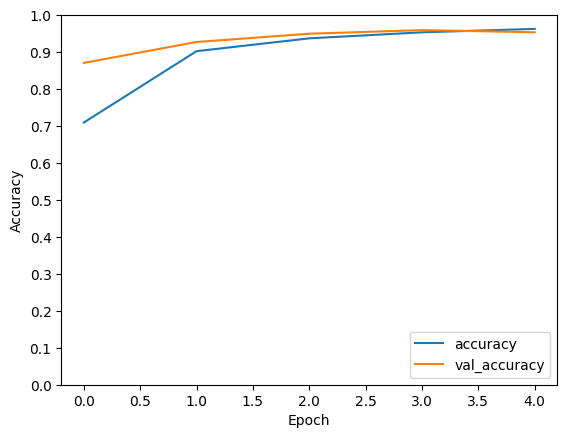

In [16]:
plt.plot(history3.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history3.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc='lower right')

val_loss, val_acc = model3.evaluate(img_val, lb_val, verbose=2)

In [17]:
predictions = model3.predict(img_test)
predictions_noisy = model3.predict(img_test_noisy)

pred_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability
pred_classes_noisy = np.argmax(predictions_noisy, axis=1)  # Get the class with the highest probability

# Calculate precision and recall
precision3 = precision_score(lb_test, pred_classes,average='micro')
precision3_noisy = precision_score(lb_test, pred_classes_noisy,average='micro')

# Print out the sizes of each split
print(f"Precision: {precision3}")
print(f"Precision (Noisy): {precision3_noisy}")

797/797 [==============================] - 1s 2ms/step
Precision: 0.9556078431372549
Precision (Noisy): 0.5469411764705883


## Model 4

### Initialize CNN model

In [ ]:
def create_model4(input_shape=(56, 56, 3)):

    model = models.Sequential()

    # First Convolutional Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and add Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    # Output layer with softmax for classification
    model.add(layers.Dense(len(class_names), activation='softmax'))

    return model


In [ ]:
model4=create_model4()
model4.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 54, 54, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 27, 27, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 9216)              0         
                                                                 
 dense_34 (Dense)            (None, 64)              

### Train model

In [ ]:
model4.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history4 = model4.fit(img_train, lb_train, epochs=5, validation_data=(img_val, lb_val))

Epoch 1/5
6383/6383 [==============================] - 93s 14ms/step - loss: 0.9691 - sparse_categorical_accuracy: 0.7256 - val_loss: 0.2889 - val_sparse_categorical_accuracy: 0.9050
Epoch 2/5
6383/6383 [==============================] - 89s 14ms/step - loss: 0.1743 - sparse_categorical_accuracy: 0.9421 - val_loss: 0.1457 - val_sparse_categorical_accuracy: 0.9507
Epoch 3/5
6383/6383 [==============================] - 89s 14ms/step - loss: 0.0877 - sparse_categorical_accuracy: 0.9708 - val_loss: 0.0595 - val_sparse_categorical_accuracy: 0.9806
Epoch 4/5
6383/6383 [==============================] - 91s 14ms/step - loss: 0.0580 - sparse_categorical_accuracy: 0.9809 - val_loss: 0.0352 - val_sparse_categorical_accuracy: 0.9880
Epoch 5/5
6383/6383 [==============================] - 92s 14ms/step - loss: 0.0446 - sparse_categorical_accuracy: 0.9854 - val_loss: 0.0477 - val_sparse_categorical_accuracy: 0.9849


### Validate model

789/789 - 4s - loss: 0.0477 - sparse_categorical_accuracy: 0.9849 - 4s/epoch - 5ms/step


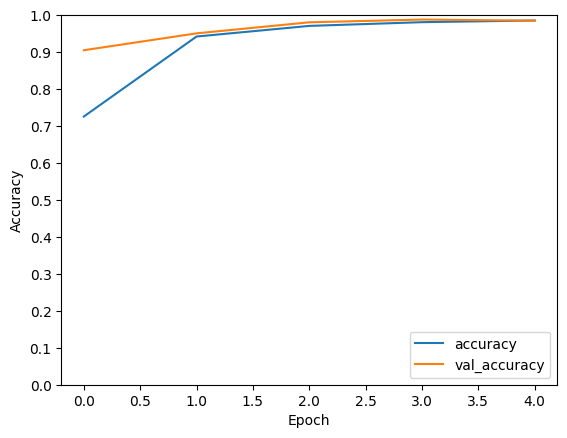

In [ ]:
plt.plot(history4.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history4.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc='lower right')

val_loss, val_acc = model4.evaluate(img_val, lb_val, verbose=2)

In [ ]:
predictions = model4.predict(img_test)
predictions_noisy = model4.predict(img_test_noisy)

pred_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability
pred_classes_noisy = np.argmax(predictions_noisy, axis=1)  # Get the class with the highest probability

# Calculate precision and recall
precision4 = precision_score(lb_test, pred_classes,average='micro')
precision4_noisy = precision_score(lb_test, pred_classes_noisy,average='micro')

# Print out the sizes of each split
print(f"Precision: {precision4}")
print(f"Precision (Noisy): {precision4_noisy}")

797/797 [==============================] - 4s 5ms/step
Precision: 0.9849803921568627
Precision (Noisy): 0.6214509803921568


# Dataset 28x28x3

## Pre processing

### Load dataset and process the images

In [ ]:
images = np.load(r"/content/drive/My Drive/dataset_IS/images_28.npy")

#images = np.load(r".\dataset\Dataset\images.npy")
#labels = np.load(r".\dataset\Dataset\labels.npy")
#class_names = np.load(r".\dataset\Dataset\class_names.npy")

# Normalize pixel values to be between 0 and 1
images = images / 255.0

# Split the dataset into training+validation (90%) and test set (10%)
img_train_val, img_test, lb_train_val, lb_test = train_test_split(images, labels, test_size=0.1, random_state=42, stratify=labels)

# Split the training+validation set into actual training (80%) and validation set (10%)
    # 0.11 x 90% ≈ 10% of the total dataset
img_train, img_val, lb_train, lb_val = train_test_split(img_train_val, lb_train_val, test_size=0.11, random_state=0, stratify=lb_train_val)


# Print out the sizes of each split
print(f"Training set: {img_train.shape[0]} images")
print(f"Validation set: {img_val.shape[0]} images")
print(f"Test set: {img_test.shape[0]} images")

Training set: 204255 images
Validation set: 25245 images
Test set: 25500 images


### Plot

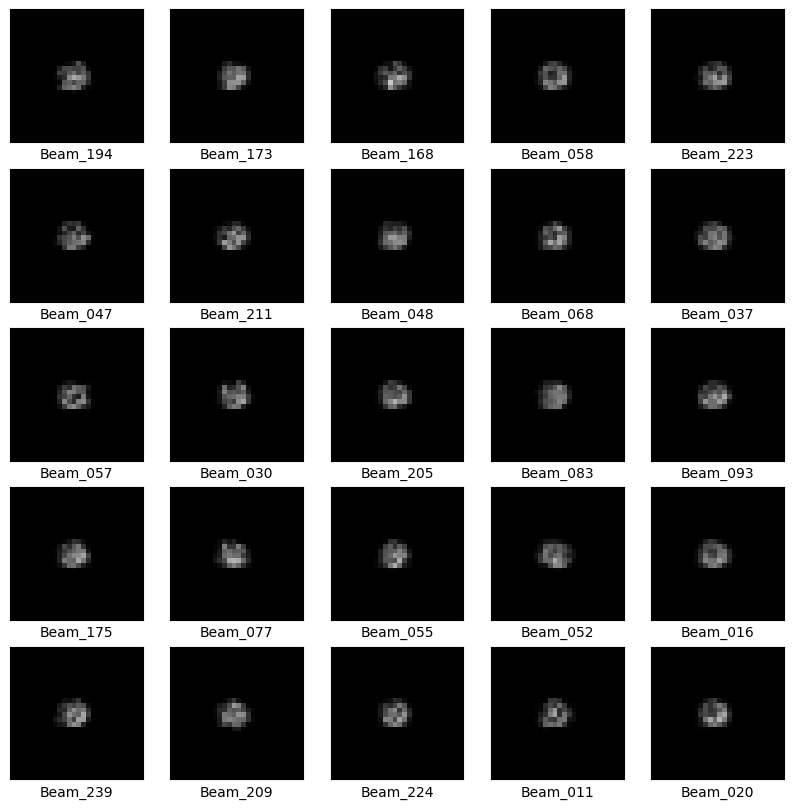

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_train[i].squeeze(), cmap='gray' if img_train[i].shape[-1] == 1 else None)
    plt.xlabel(class_names[lb_train[i]])
plt.show()

## Model 3

### Initialize NN model


In [ ]:
model3_2=create_model3(input_shape=(28, 28, 3))
model3_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 2352)              0         
                                                                 
 dense_13 (Dense)            (None, 64)                150592    
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 255)               16575     
                                                                 
Total params: 171327 (669.25 KB)
Trainable params: 171327 (669.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train model


In [ ]:
model3_2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history3_2 = model3_2.fit(img_train, lb_train, epochs=5, validation_data=(img_val, lb_val))

Epoch 1/5
6383/6383 [==============================] - 23s 3ms/step - loss: 2.9415 - sparse_categorical_accuracy: 0.2401 - val_loss: 2.1922 - val_sparse_categorical_accuracy: 0.3639
Epoch 2/5
6383/6383 [==============================] - 21s 3ms/step - loss: 2.0181 - sparse_categorical_accuracy: 0.4013 - val_loss: 1.8739 - val_sparse_categorical_accuracy: 0.4331
Epoch 3/5
6383/6383 [==============================] - 22s 3ms/step - loss: 1.7607 - sparse_categorical_accuracy: 0.4604 - val_loss: 1.6492 - val_sparse_categorical_accuracy: 0.4921
Epoch 4/5
6383/6383 [==============================] - 21s 3ms/step - loss: 1.5790 - sparse_categorical_accuracy: 0.5087 - val_loss: 1.5360 - val_sparse_categorical_accuracy: 0.5265
Epoch 5/5
6383/6383 [==============================] - 21s 3ms/step - loss: 1.4684 - sparse_categorical_accuracy: 0.5390 - val_loss: 1.4525 - val_sparse_categorical_accuracy: 0.5489


### Validate model

789/789 - 1s - loss: 1.4525 - sparse_categorical_accuracy: 0.5489 - 1s/epoch - 2ms/step


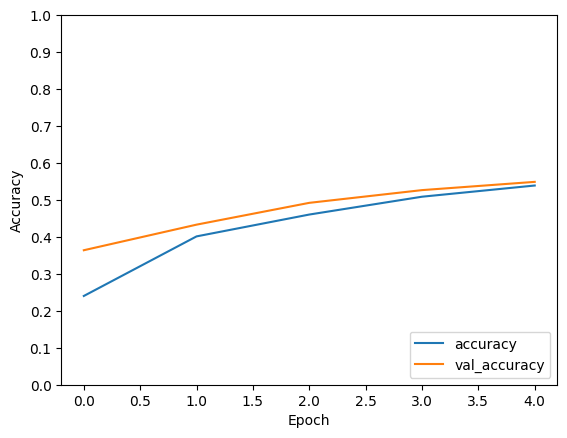

In [ ]:
plt.plot(history3_2.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history3_2.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc='lower right')

val_loss, val_acc = model3_2.evaluate(img_val, lb_val, verbose=2)

In [ ]:
predictions = model3_2.predict(img_test)
pred_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# Calculate precision and recall
precision3_2 = precision_score(lb_test, pred_classes,average='micro')

# Print out the sizes of each split
print(f"Precision: {precision3_2}")

797/797 [==============================] - 1s 2ms/step
Precision: 0.5427450980392157


## Model 4

### Initialize CNN model


In [ ]:
model4_2=create_model4(input_shape=(28, 28, 3))
model4_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1600)              0         
                                                                 
 dense_16 (Dense)            (None, 64)               

### Train model


In [ ]:
model4_2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history4_2 = model4_2.fit(img_train, lb_train, epochs=5, validation_data=(img_val, lb_val))

Epoch 1/5
6383/6383 [==============================] - 45s 7ms/step - loss: 2.5695 - sparse_categorical_accuracy: 0.3168 - val_loss: 1.6566 - val_sparse_categorical_accuracy: 0.4824
Epoch 2/5
6383/6383 [==============================] - 43s 7ms/step - loss: 1.4347 - sparse_categorical_accuracy: 0.5420 - val_loss: 1.2725 - val_sparse_categorical_accuracy: 0.5906
Epoch 3/5
6383/6383 [==============================] - 44s 7ms/step - loss: 1.1719 - sparse_categorical_accuracy: 0.6139 - val_loss: 1.1043 - val_sparse_categorical_accuracy: 0.6318
Epoch 4/5
6383/6383 [==============================] - 44s 7ms/step - loss: 1.0516 - sparse_categorical_accuracy: 0.6492 - val_loss: 1.0454 - val_sparse_categorical_accuracy: 0.6467
Epoch 5/5
6383/6383 [==============================] - 44s 7ms/step - loss: 0.9789 - sparse_categorical_accuracy: 0.6687 - val_loss: 0.9775 - val_sparse_categorical_accuracy: 0.6684


### Validate model

789/789 - 2s - loss: 0.9775 - sparse_categorical_accuracy: 0.6684 - 2s/epoch - 3ms/step


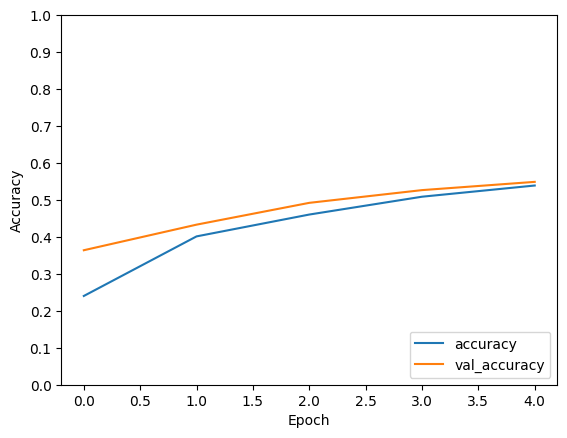

In [ ]:
plt.plot(history3_2.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history3_2.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc='lower right')

val_loss, val_acc = model4_2.evaluate(img_val, lb_val, verbose=2)

In [ ]:
predictions = model4_2.predict(img_test)
pred_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# Calculate precision and recall
precision4_2 = precision_score(lb_test, pred_classes,average='micro')

# Print out the sizes of each split
print(f"Precision: {precision4_2}")

797/797 [==============================] - 2s 3ms/step
Precision: 0.6672549019607843



# Dataset 56x56x1

## Pre processing

### Load dataset and process the images

In [ ]:
images = np.load(r"/content/drive/My Drive/dataset_IS/images_56L.npy")

#images = np.load(r".\dataset\Dataset\images.npy")
#labels = np.load(r".\dataset\Dataset\labels.npy")
#class_names = np.load(r".\dataset\Dataset\class_names.npy")

# Normalize pixel values to be between 0 and 1
images = images / 255.0

# Split the dataset into training+validation (90%) and test set (10%)
img_train_val, img_test, lb_train_val, lb_test = train_test_split(images, labels, test_size=0.1, random_state=42, stratify=labels)

# Split the training+validation set into actual training (80%) and validation set (10%)
    # 0.11 x 90% ≈ 10% of the total dataset
img_train, img_val, lb_train, lb_val = train_test_split(img_train_val, lb_train_val, test_size=0.11, random_state=0, stratify=lb_train_val)


# Print out the sizes of each split
print(f"Training set: {img_train.shape[0]} images")
print(f"Validation set: {img_val.shape[0]} images")
print(f"Test set: {img_test.shape[0]} images")

Training set: 204255 images
Validation set: 25245 images
Test set: 25500 images


### Plot

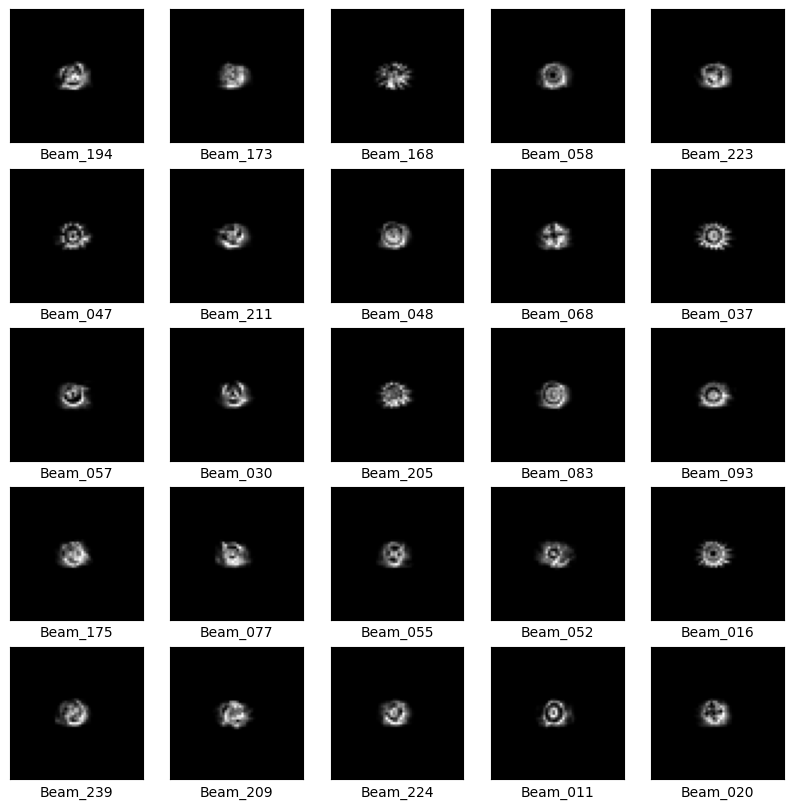

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img_train[i].squeeze(), cmap='gray' if img_train[i].shape[-1] == 1 else None)
    plt.xlabel(class_names[lb_train[i]])
plt.show()

## Model 3

### Initialize NN model


In [ ]:
model3_3=create_model3(input_shape=(56, 56, 1))
model3_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 3136)              0         
                                                                 
 dense_18 (Dense)            (None, 64)                200768    
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 255)               16575     
                                                                 
Total params: 221503 (865.25 KB)
Trainable params: 221503 (865.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train model


In [ ]:
model3_3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history3_3 = model3_3.fit(img_train, lb_train, epochs=5, validation_data=(img_val, lb_val))

Epoch 1/5
6383/6383 [==============================] - 24s 4ms/step - loss: 1.1619 - sparse_categorical_accuracy: 0.6855 - val_loss: 0.4185 - val_sparse_categorical_accuracy: 0.8670
Epoch 2/5
6383/6383 [==============================] - 22s 3ms/step - loss: 0.3136 - sparse_categorical_accuracy: 0.9017 - val_loss: 0.2301 - val_sparse_categorical_accuracy: 0.9276
Epoch 3/5
6383/6383 [==============================] - 22s 3ms/step - loss: 0.1954 - sparse_categorical_accuracy: 0.9379 - val_loss: 0.1612 - val_sparse_categorical_accuracy: 0.9488
Epoch 4/5
6383/6383 [==============================] - 22s 3ms/step - loss: 0.1419 - sparse_categorical_accuracy: 0.9538 - val_loss: 0.1248 - val_sparse_categorical_accuracy: 0.9589
Epoch 5/5
6383/6383 [==============================] - 22s 3ms/step - loss: 0.1093 - sparse_categorical_accuracy: 0.9640 - val_loss: 0.0990 - val_sparse_categorical_accuracy: 0.9671


### Validate model

789/789 - 1s - loss: 0.0990 - sparse_categorical_accuracy: 0.9671 - 1s/epoch - 2ms/step


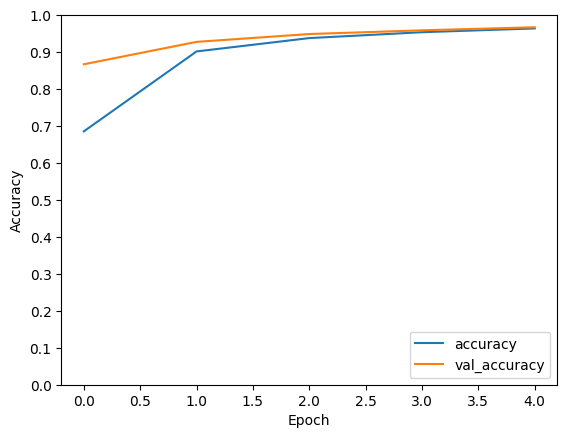

In [ ]:
plt.plot(history3_3.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history3_3.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc='lower right')

val_loss, val_acc = model3_3.evaluate(img_val, lb_val, verbose=2)

In [ ]:
predictions = model3_3.predict(img_test)
pred_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# Calculate precision and recall
precision3_3 = precision_score(lb_test, pred_classes,average='micro')

# Print out the sizes of each split
print(f"Precision: {precision3_3}")

797/797 [==============================] - 1s 2ms/step
Precision: 0.9705098039215686


## Model 4

### Initialize CNN model


In [ ]:
model4_3=create_model4(input_shape=(56, 56, 1))
model4_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 54, 54, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 27, 27, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 9216)              0         
                                                                 
 dense_21 (Dense)            (None, 64)               

### Train model


In [ ]:
model4_3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history4_3 = model4_3.fit(img_train, lb_train, epochs=5, validation_data=(img_val, lb_val))

Epoch 1/5
6383/6383 [==============================] - 89s 14ms/step - loss: 1.1908 - sparse_categorical_accuracy: 0.6590 - val_loss: 0.4715 - val_sparse_categorical_accuracy: 0.8324
Epoch 2/5
6383/6383 [==============================] - 87s 14ms/step - loss: 0.2798 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.2192 - val_sparse_categorical_accuracy: 0.9276
Epoch 3/5
6383/6383 [==============================] - 87s 14ms/step - loss: 0.1476 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.1312 - val_sparse_categorical_accuracy: 0.9565
Epoch 4/5
6383/6383 [==============================] - 86s 13ms/step - loss: 0.0939 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.0804 - val_sparse_categorical_accuracy: 0.9744
Epoch 5/5
6383/6383 [==============================] - 84s 13ms/step - loss: 0.0661 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.1202 - val_sparse_categorical_accuracy: 0.9612


### Validate model

789/789 - 3s - loss: 0.1202 - sparse_categorical_accuracy: 0.9612 - 3s/epoch - 4ms/step


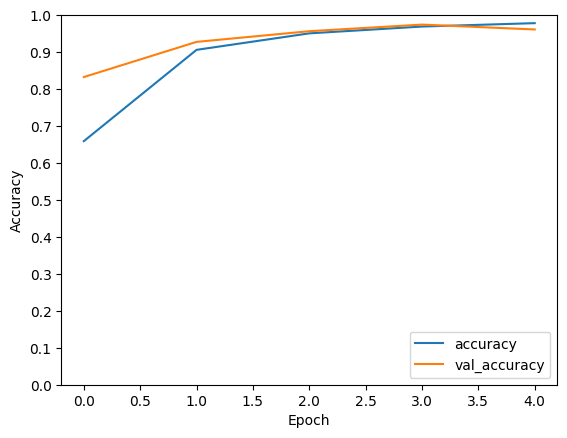

In [ ]:
plt.plot(history4_3.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history4_3.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc='lower right')

val_loss, val_acc = model4_3.evaluate(img_val, lb_val, verbose=2)

In [ ]:
predictions = model4_3.predict(img_test)
pred_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

# Calculate precision and recall
precision4_3 = precision_score(lb_test, pred_classes,average='micro')

# Print out the sizes of each split
print(f"Precision: {precision4_3}")

797/797 [==============================] - 4s 5ms/step
Precision: 0.9606274509803922
